# Детектирование пожаров с помощью нейросети

In [1]:
# импорт библиотек
import os
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Dense, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout
from tensorflow.keras.optimizers import SGD

In [2]:
# константы
INIT_LR = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 50
lr_find = True

In [3]:
# загрузка данных
with open('data/train/annotations/instances_default.json', 'r') as file:
    json_train = json.load(file)

with open('data/val/annotations/instances_default.json', 'r') as file:
    json_val = json.load(file)

In [4]:
# загрузка данных
paths_train = os.listdir('data/train/images/train')
paths_val = os.listdir('data/val/images/val')

In [5]:
# преобразование в таблицы
images_train_pd = pd.DataFrame(json_train['images'])[['file_name', 'id']]
annotations_train_pd = pd.DataFrame(json_train['annotations'])[['image_id', 'category_id']]
annotations_train_pd.columns = ['id', 'category_id']
train_paths = pd.merge(images_train_pd, annotations_train_pd, on='id').drop_duplicates(subset='id')

images_val_pd = pd.DataFrame(json_val['images'])[['file_name', 'id']]
annotations_val_pd = pd.DataFrame(json_val['annotations'])[['image_id', 'category_id']]
annotations_val_pd.columns = ['id', 'category_id']
val_paths = pd.merge(images_val_pd, annotations_val_pd, on='id').drop_duplicates(subset='id')

train_paths.shape, val_paths.shape

((1142, 3), (308, 3))

In [6]:
# получение изображений и меток
images_train = []
labels_train = []
for i, path in enumerate(train_paths['file_name']):
    try:
        image = cv2.imread('data/train/images/' + path)
        image = cv2.resize(image, (128,128))
        images_train.append(image)

        labels_train.append(train_paths['category_id'].iloc[i])
    except:
        pass
    
images_train = np.array(images_train, dtype='float32')/255.

images_val = []
labels_val = []
for i, path in enumerate(val_paths['file_name']):
    try:
        image = cv2.imread('data/val/images/' + path)
        image = cv2.resize(image, (128,128))
        images_val.append(image)

        labels_val.append(val_paths['category_id'].iloc[i])
    except:
        pass
    
images_val = np.array(images_val, dtype='float32')/255.

images_train.shape, len(labels_train), images_val.shape, len(labels_val)

((1142, 128, 128, 3), 1142, (308, 128, 128, 3), 308)

In [7]:
# преобразование меток для обучения
labels_train_fire = []
for i in labels_train:
    if i == 5:
        labels_train_fire.append([1, 0])
    else:
        labels_train_fire.append([0, 1])
labels_train_fire = np.array(labels_train_fire, dtype='float32')

labels_val_fire = []
for i in labels_val:
    if i == 5:
        labels_val_fire.append([1, 0])
    else:
        labels_val_fire.append([0, 1])
labels_val_fire = np.array(labels_val_fire, dtype='float32')

labels_train_smoke = []
for i in labels_train:
    if i == 4:
        labels_train_smoke.append([1, 0])
    else:
        labels_train_smoke.append([0, 1])
labels_train_smoke = np.array(labels_train_smoke, dtype='float32')

labels_val_smoke = []
for i in labels_val:
    if i == 4:
        labels_val_smoke.append([1, 0])
    else:
        labels_val_smoke.append([0, 1])
labels_val_smoke = np.array(labels_val_smoke, dtype='float32')

In [8]:
# расчет весов классов
class_weight_fire = {1: len([label for label in  labels_train + labels_val if label == 5])/len(labels_train + labels_val), 
                     0 : 1 - len([label for label in  labels_train + labels_val if label == 5])/len(labels_train + labels_val)}

class_weight_smoke = {1: len([label for label in  labels_train + labels_val if label == 4])/len(labels_train + labels_val), 
                     0 : 1 - len([label for label in  labels_train + labels_val if label == 5])/len(labels_train + labels_val)}

class_weight_fire, class_weight_smoke

({1: 0.4924137931034483, 0: 0.5075862068965518},
 {1: 0.31517241379310346, 0: 0.5075862068965518})

In [9]:
# аугментация
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
# создание модели
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(16,(7,7),padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => POOL
model.add(SeparableConv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(2))
model.add(Activation("softmax"))

opt = SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

c:\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 128, 128, 16)   │           211 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 64, 64, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 32, 32, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 32, 32, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,123,813 (8.10 MB)

 Trainable params: 2,122,949 (8.10 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [11]:
# обучение и сохранение модели для детекции огня
print("[INFO] training network...")

H = model.fit(
    aug.flow(images_train, labels_train_fire, batch_size=BATCH_SIZE),
    validation_data=(images_val, labels_val_fire),
    steps_per_epoch = images_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=class_weight_fire,
    verbose=1)

print("[INFO] serializing network to '{}'...".format('output/model'))
model.save('output/fire_detection.h5')

c:\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[INFO] training network...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 920ms/step - accuracy: 0.4951 - loss: 0.4765 - val_accuracy: 0.5260 - val_loss: 2.5563
Epoch 2/50
 1/17 ━━━━━━━━━━━━━━━━━━━━ 11s 738ms/step - accuracy: 0.5156 - loss: 0.4182

c:\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5156 - loss: 0.4182 - val_accuracy: 0.5325 - val_loss: 2.2801
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 916ms/step - accuracy: 0.5129 - loss: 0.4117 - val_accuracy: 0.5162 - val_loss: 1.6055
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4531 - loss: 0.3636 - val_accuracy: 0.5000 - val_loss: 2.3085
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 892ms/step - accuracy: 0.4837 - loss: 0.3848 - val_accuracy: 0.4740 - val_loss: 4.8421
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5625 - loss: 0.3662 - val_accuracy: 0.4740 - val_loss: 3.9460
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 930ms/step - accuracy: 0.4952 - loss: 0.3847 - val_accuracy: 0.5032 - val_loss: 1.7999
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5469 - loss: 0.3721 - val_accuracy: 0.4968 - val_loss: 1.9381
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 942ms/step - accuracy: 0.5125 - loss: 0.3736 - val_accuracy: 0.5227 - val_

[INFO] serializing network to 'output/model'...


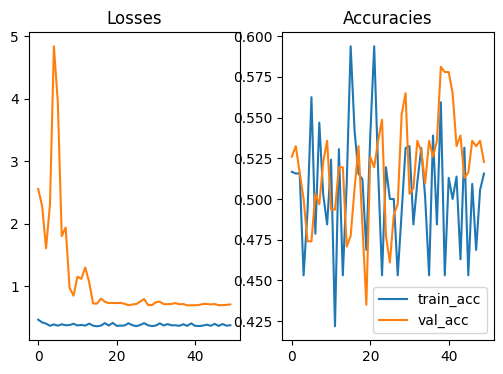

In [12]:
# кривая обучения
N = np.arange(0, NUM_EPOCHS)

plt.figure(figsize=(6,4))

plt.subplot(121)
plt.title("Losses")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")

plt.subplot(122)
plt.title("Accuracies")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")


plt.legend()
plt.savefig("output/training_plot.png")

In [13]:
# обучение и сохранение модели для детекции дыма
print("[INFO] training network...")

H1 = model.fit(
    aug.flow(images_train, labels_train_smoke, batch_size=BATCH_SIZE),
    validation_data=(images_val, labels_val_smoke),
    steps_per_epoch = images_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight = class_weight_smoke,
    verbose=1)

print("[INFO] serializing network to '{}'...".format('output/model'))
model.save('output/smoke_detection.h5')

[INFO] training network...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4818 - loss: 0.2928 - val_accuracy: 0.5390 - val_loss: 0.6946
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4375 - loss: 0.2802 - val_accuracy: 0.5584 - val_loss: 0.6841
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5836 - loss: 0.2678 - val_accuracy: 0.6753 - val_loss: 0.6260
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5312 - loss: 0.3076 - val_accuracy: 0.6623 - val_loss: 0.6291
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5838 - loss: 0.2703 - val_accuracy: 0.6818 - val_loss: 0.6288
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5938 - loss: 0.2599 - val_accuracy: 0.6688 - val_loss: 0.6366
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6298 - loss: 0.2630 - val_accuracy: 0.6266 - val_loss: 0.6401
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6562 - loss: 0.2397 - v

[INFO] serializing network to 'output/model'...


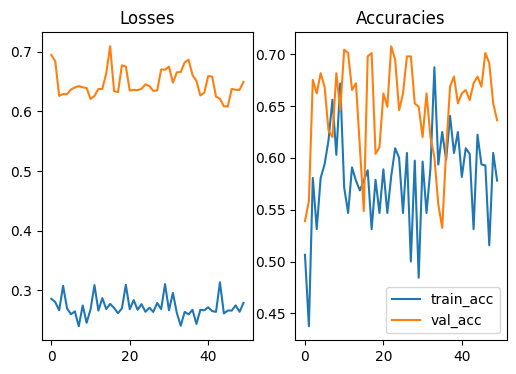

In [14]:
# кривая обучения
N1 = np.arange(0, NUM_EPOCHS)

plt.figure(figsize=(6,4))

plt.subplot(121)
plt.title("Losses")
plt.plot(N1, H1.history["loss"], label="train_loss")
plt.plot(N1, H1.history["val_loss"], label="val_loss")

plt.subplot(122)
plt.title("Accuracies")
plt.plot(N1, H1.history["accuracy"], label="train_acc")
plt.plot(N1, H1.history["val_accuracy"], label="val_acc")


plt.legend()
plt.savefig("output/training_plot.png")